# Kaggle Imports
---
Uncomment and run those cells if you're working on Cloud and you need to import the dataset!

- Use this on Colab to import your api json
  

In [265]:
'''
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
'''

mv: cannot stat 'kaggle.json': No such file or directory


- Install Kaggle and import then unzip dataset

In [2]:
'''
!pip install pandas
!pip install kaggle
!kaggle datasets download -d najzeko/steam-reviews-2021
!unzip steam-reviews-2021.zip
'''


100%|██████████████████████████████████████| 2.97G/2.97G [04:29<00:00, 11.0MB/s]
100%|██████████████████████████████████████| 2.97G/2.97G [04:29<00:00, 11.9MB/s]
Archive:  steam-reviews-2021.zip
  inflating: steam_reviews.csv       


  # Libraries and Functions imports

In [54]:
import pandas as pd
import numpy as np        
from datetime import datetime
import matplotlib.pyplot as plt

In [55]:
dataframe = pd.read_csv('./steam_reviews.csv', nrows= 5000000)
print(dataframe.columns)

Index(['Unnamed: 0', 'app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')


# [RQ1]

In [56]:
print(dataframe.shape)


(5000000, 23)


In this dataset we have Nrows and 23 variables.

In [57]:
dataframe.head(3)

,Unnamed: 0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,1611381629,1611381629,True,0,...,True,False,False,76561199095369542,6,2,1909.0,1448.0,1909.0,1.611343e+09
1,1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,1611381030,1611381030,True,0,...,True,False,False,76561198949504115,30,10,2764.0,2743.0,2674.0,1.611386e+09
2,2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,1611380800,1611380800,True,0,...,True,False,False,76561199090098988,5,1,1061.0,1061.0,1060.0,1.611384e+09


In [58]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 23 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   Unnamed: 0                      int64  
 1   app_id                          int64  
 2   app_name                        object 
 3   review_id                       int64  
 4   language                        object 
 5   review                          object 
 6   timestamp_created               int64  
 7   timestamp_updated               int64  
 8   recommended                     bool   
 9   votes_helpful                   int64  
 10  votes_funny                     int64  
 11  weighted_vote_score             float64
 12  comment_count                   int64  
 13  steam_purchase                  bool   
 14  received_for_free               bool   
 15  written_during_early_access     bool   
 16  author.steamid                  int64  
 17  author.num_games_owned     

[0, 1, 2, 3, 5, 10, 50, 3631553]


<Figure size 432x288 with 0 Axes>

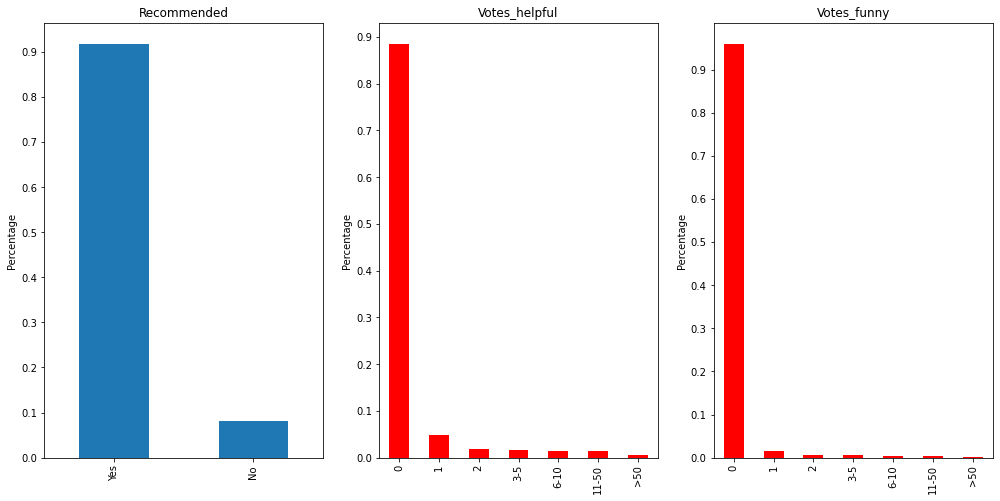

In [75]:
recomm_amount = dataframe["recommended"].value_counts()
recomm_amount = recomm_amount/sum(recomm_amount)
#print(recomm_amount)

helpful=dataframe["votes_helpful"].value_counts()
my_bins=[0,1,2,3,5,10,50,helpful.max()]
print(my_bins)
out=pd.cut(dataframe["votes_helpful"],bins=my_bins,include_lowest=True)
ax=out.value_counts(sort=False)
ax=ax/sum(ax)
#print(ax)

funny=dataframe["votes_funny"].value_counts()
my_bins=[0,1,2,3,5,10,50,funny.max()]
out2=pd.cut(dataframe["votes_funny"],bins=my_bins,include_lowest=True)
bx=out2.value_counts(sort=False)
bx=bx/sum(bx)
#print(bx)



plt.figure()
fig=plt.figure(figsize=(17,8))
plt.subplot(131)
recomm_amount.plot.bar(
    title='Recommended',
ylabel='Percentage',)
plt.yticks(np.arange(0,1,0.1))
plt.xticks([0,1],['Yes','No'])

plt.subplot(132)
ax.plot.bar(color='r',title="Votes_helpful",ylabel='Percentage')
plt.xticks([0,1,2,3,4,5,6],['0','1','2','3-5','6-10','11-50','>50'])
plt.yticks(np.arange(0,1,0.1))

plt.subplot(133)
bx.plot.bar(color='r',title="Votes_funny",ylabel='Percentage')
plt.xticks([0,1,2,3,4,5,6],['0','1','2','3-5','6-10','11-50','>50'])
plt.yticks(np.arange(0,1,0.1))

plt.show()

<Figure size 432x288 with 0 Axes>

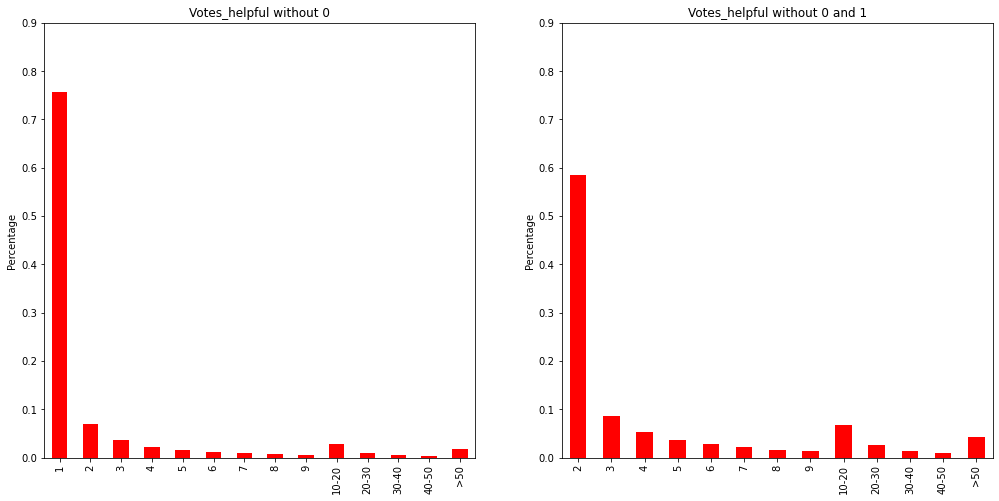

In [79]:
##TEST!
##Analyzing the comments without 0 helpful vote and without 0 and 1, the most commons
helpful2=dataframe[dataframe.votes_helpful>0]["votes_helpful"]
my_bins=[1,2,3,4,5,6,7,8,9,10,20,30,40,50,helpful2.max()]
out=pd.cut(helpful2,bins=my_bins,include_lowest=True)
ax=out.value_counts(sort=False)
ax=ax/sum(ax)
#print(ax)


plt.figure()
fig=plt.figure(figsize=(17,8))
plt.subplot(121)
ax.plot.bar(color='r',title="Votes_helpful without 0",ylabel='Percentage')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],['1','2','3','4','5','6','7','8','9','10-20','20-30','30-40','40-50','>50'])
plt.yticks(np.arange(0,1,0.1))


helpful3=dataframe[dataframe.votes_helpful>1]["votes_helpful"]
my_bins=[2,3,4,5,6,7,8,9,10,20,30,40,50,helpful2.max()]
out2=pd.cut(helpful2,bins=my_bins,include_lowest=True)
bx=out2.value_counts(sort=False)
bx=bx/sum(bx)
#print(bx)

plt.subplot(122)
bx.plot.bar(color='r',title="Votes_helpful without 0 and 1",ylabel='Percentage')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12],['2','3','4','5','6','7','8','9','10-20','20-30','30-40','40-50','>50'])
plt.yticks(np.arange(0,1,0.1))


plt.show()

In [80]:
weighted=dataframe["weighted_vote_score"]
plt.figure()
fig=plt.figure(figsize=(5,6))

#weighted.plot(kind='box')

<Figure size 432x288 with 0 Axes>

<Figure size 360x432 with 0 Axes>

In [81]:
dataframe.corr()

,Unnamed: 0,app_id,review_id,timestamp_created,timestamp_updated,recommended,votes_helpful,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
Unnamed: 0,1.000000,0.524016,0.124508,0.137937,0.130387,-0.056750,0.007424,-0.001135,0.000079,-0.005111,-0.008731,-0.002604,0.206403,0.000301,0.000312,0.004471,-0.070620,0.017652,-0.083798,0.112901
app_id,0.524016,1.000000,0.301433,0.334128,0.322653,-0.216370,0.017234,-0.001708,0.032927,-0.001978,0.005030,-0.008399,0.204868,0.018527,-0.000483,-0.007531,-0.114138,0.026615,-0.120711,0.181634
review_id,0.124508,0.301433,1.000000,0.971143,0.935846,0.030895,-0.021407,-0.005681,-0.207032,-0.050546,0.089569,0.035097,-0.171629,0.465596,-0.000412,-0.075352,-0.087793,0.130702,-0.018985,0.481795
timestamp_created,0.137937,0.334128,0.971143,1.000000,0.962345,0.016022,-0.019064,-0.005238,-0.185133,-0.048724,0.097820,0.042656,-0.146601,0.437671,-0.000356,-0.070705,-0.083226,0.110265,-0.020076,0.507079
timestamp_updated,0.130387,0.322653,0.935846,0.962345,1.000000,0.012449,-0.017018,-0.005024,-0.169687,-0.040561,0.094722,0.040644,-0.156496,0.423419,-0.000389,-0.054913,-0.042971,0.118901,0.025457,0.521500
recommended,-0.056750,-0.216370,0.030895,0.016022,0.012449,1.000000,-0.040110,-0.000718,-0.200645,-0.070795,0.052154,-0.006647,-0.033081,0.070616,0.000133,-0.034174,0.025064,0.013823,0.018574,0.102224
votes_helpful,0.007424,0.017234,-0.021407,-0.019064,-0.017018,-0.040110,1.000000,0.000188,0.139252,0.455662,-0.007515,-0.001804,0.012933,-0.020569,-0.000027,0.022552,0.013719,-0.000064,0.010817,-0.014154
votes_funny,-0.001135,-0.001708,-0.005681,-0.005238,-0.005024,-0.000718,0.000188,1.000000,0.007391,0.000864,-0.000161,-0.000447,0.001568,-0.002586,-0.000002,0.000784,0.000731,-0.000702,0.000374,-0.002107
weighted_vote_score,0.000079,0.032927,-0.207032,-0.185133,-0.169687,-0.200645,0.139252,0.007391,1.000000,0.108773,-0.049887,0.010462,0.066515,-0.129955,-0.000295,0.093872,0.061811,-0.009946,0.028476,-0.083499
comment_count,-0.005111,-0.001978,-0.050546,-0.048724,-0.040561,-0.070795,0.455662,0.000864,0.108773,1.000000,-0.009925,0.003231,0.012483,-0.031849,-0.000033,0.034760,0.041907,0.004207,0.032701,-0.025770


# [RQ2] Let's explore the dataset by finding simple insights into the reviews.
---

### Plot the number of reviews for each application in descending order.

Text(0, 0.5, 'Reviews Amount')

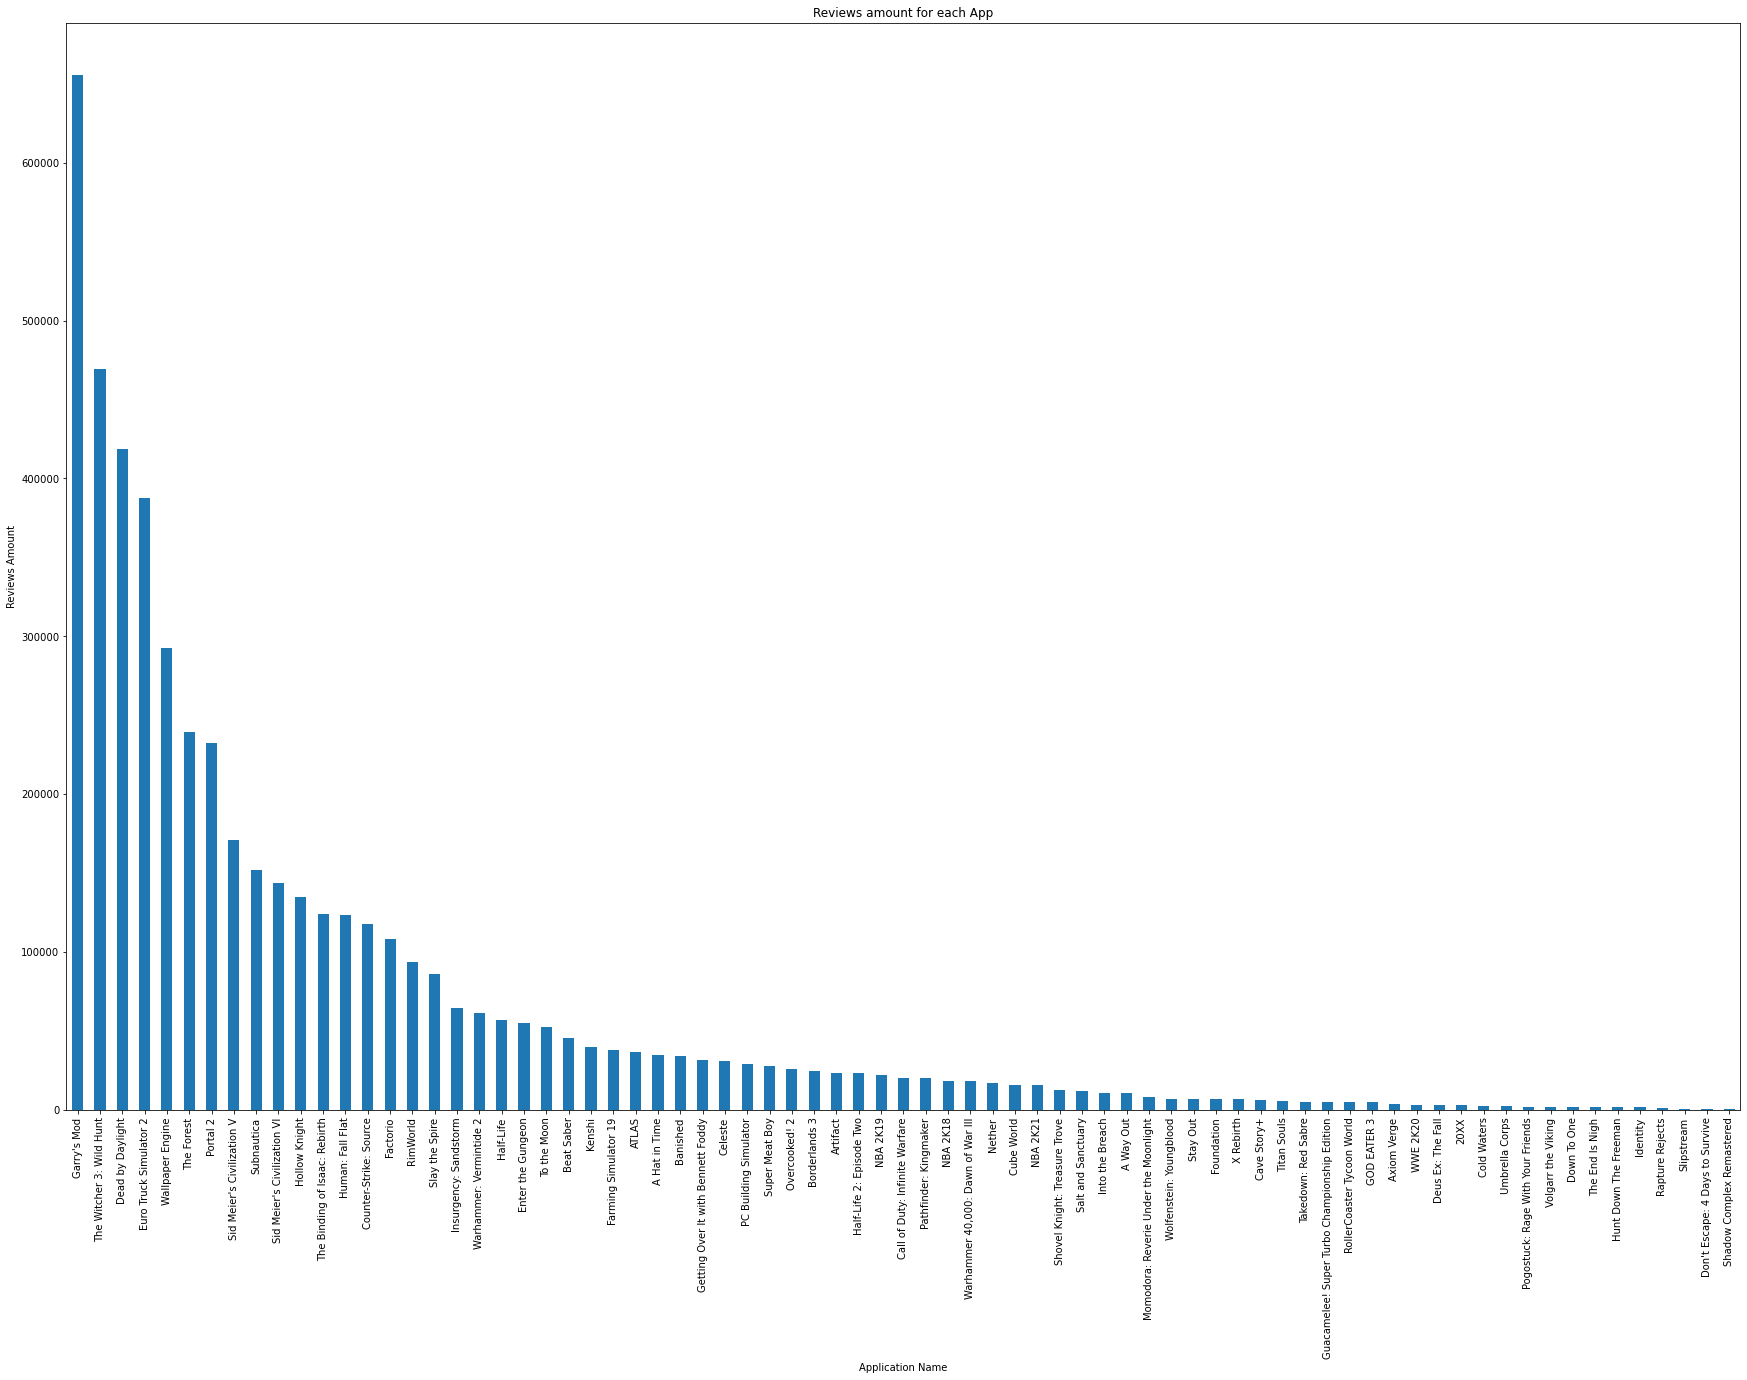

In [82]:
reviewsAmounts = dataframe['app_name'].value_counts()
ra_plot = reviewsAmounts.plot(kind='bar',
                                    figsize=(30,20),
                                    title="Reviews amount for each App")
ra_plot.set_xlabel("Application Name")
ra_plot.set_ylabel("Reviews Amount")
#plt.show()

### Find out are the most and least reviewed applications

In [83]:
print(reviewsAmounts.idxmax())
print(reviewsAmounts.idxmin())

Garry's Mod
Shadow Complex Remastered


### What applications have the best Weighted Vote Score?


In [84]:
# daframe.sort_values('weighted_vote_score')
scores = dataframe['weighted_vote_score']
max = scores.idxmax()

print(dataframe[dataframe['weighted_vote_score'] == dataframe['weighted_vote_score'].max()]['app_name'])


2353895    Subnautica
Name: app_name, dtype: object


### Which applications have the most and the least recommendations?


In [85]:
recommended = dataframe.groupby('app_name')['recommended'].apply(lambda r : (r == True).sum()).reset_index(name = 'recommendations')
max_min_recommendations = recommended[
        (recommended['recommendations'] == recommended['recommendations'].max()) |
        (recommended['recommendations'] == recommended['recommendations'].min())
      ]
print(max_min_recommendations)

       app_name  recommendations
25  Garry's Mod           632558
33     Identity              439


### How many of these applications were purchased, and how many were given for free?


In [86]:
print((dataframe)['received_for_free'].agg({'Given for free' : lambda x : (x == True).sum(), 'Purchased' : lambda y : (y == False).sum()}))

Given for free     137647
Purchased         4862353
Name: received_for_free, dtype: int64


# [RQ3]  Now it's important to understand the preferred time to do reviews.
---


### What is the most common time that authors review an application? For example, authors usually write a review at 17:44.

In [87]:
timeframes = pd.to_datetime(dataframe['timestamp_created'].apply(lambda time : (datetime.fromtimestamp(time))))

In [88]:
modes = timeframes.dt.time.mode()
print("People usually write reviews at: ")
[print(time.strftime('%H:%M') ) for time in modes.values]

People usually write reviews at: 
16:54


[None]

### Create a function that receives as a parameter a list of time intervals and returns the plot the number of reviews for each of the intervals.


In [89]:
# Counting how many datetime occurences in input_timeframes belong to each interval in intervals
#
# Parameters :
# [intervals] : List of datetime tuples (interval_start, interval_end)
# such that they define time intervals. E.G. = (06:00, 12:00). [start] has to be lesser than [end]
# [input_timeframes] : input list of (DateTime objects)
#
# Returns : A Pandas dataframe with input_timeframes grouped by intervals.
#           E.G. : 
#           '    Interval   |   Reviews    '
#           ' --------------|--------------'
#           ' 06:00 - 09:59 |    100000    '
#           ' 10:00 - 11:59 |     30000    '
#           '------------------------------'
def count_reviews_in_belonging_t_interval(intervals, input_timeframes):

    df_timeframes = pd.DataFrame()
    df_timeframes['times'] = input_timeframes
    df_timeframes.index = pd.to_datetime(input_timeframes)
    output = pd.DataFrame({'Interval' : [], 'Reviews' : []})

    for (start,end) in intervals :
        assert(start < end), 'Input Mismatch: DateTime interval had start greater than end!'
        
        start = start.strftime('%H:%M')
        end = end.strftime('%H:%M')
        r_amount = len(df_timeframes.between_time(start, end))
        output = output.append(pd.DataFrame({'Interval' : ['{}-{}'.format(start,end)], 'Reviews': [r_amount]}), ignore_index = True)
    return output


### Use the function that you created in the previous literal to plot the number of reviews between the following time intervals:

<AxesSubplot:xlabel='Interval'>

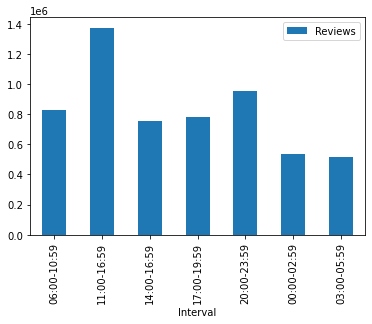

In [90]:
# Defining said intervals as datetime objects
intervals = [
    ( datetime.strptime('06:00:00', "%H:%M:%S"), datetime.strptime('10:59:59', "%H:%M:%S") ),
    ( datetime.strptime('11:00:00', "%H:%M:%S"), datetime.strptime('16:59:59', "%H:%M:%S") ),
    ( datetime.strptime('14:00:00', "%H:%M:%S"), datetime.strptime('16:59:59', "%H:%M:%S") ), 
    ( datetime.strptime('17:00:00', "%H:%M:%S"), datetime.strptime('19:59:59', "%H:%M:%S") ),
    ( datetime.strptime('20:00:00', "%H:%M:%S"), datetime.strptime('23:59:59', "%H:%M:%S") ),
    ( datetime.strptime('00:00:00', "%H:%M:%S"), datetime.strptime('02:59:59', "%H:%M:%S") ),
    ( datetime.strptime('03:00:00', "%H:%M:%S"), datetime.strptime('05:59:59', "%H:%M:%S") )
]

# Counnting how many reviews have been placed in said intervals
output = count_reviews_in_belonging_t_interval(intervals, timeframes)
output.plot(x = 'Interval', y='Reviews', kind='bar')

# [RQ4] As Steam is a worldwide platform, the reviews can be done in many languages. Let's extract some information about it.

### What are the top 3 languages used to review applications?

In [91]:
top_3_languages = dataframe['language'].value_counts()[:3].index.tolist()
print(top_3_languages)

['english', 'schinese', 'russian']


### Create a function that receives as parameters both the name of a data set and a list of languages’ names and returns a data frame filtered only with the reviews written in the provided languages.

In [92]:
def filter_dataset_on_languages(dataset, languages) :
    return dataset[dataset['language'].isin(languages)]


### Use the function created in the previous literal to find what percentage of these reviews (associated with the top 3 languages) were voted as funny?

In [93]:
filtered_ds = filter_dataset_on_languages(dataframe, top_3_languages)

In [94]:
print('{:.2f}%'.format(100 * (len(filtered_ds[filtered_ds['votes_funny'] > 0])) / len(filtered_ds)))

11.99%


### Use the function created in the literal “a” to find what percentage of these reviews (associated with the top 3 languages) were voted as helpful?

In [95]:
print('{:.2f}%'.format(100 * (len(filtered_ds[filtered_ds['votes_helpful'] > 0])) / len(filtered_ds)))

28.50%


# [RQ5] The reviews' authors are users from the game that provide their opinion on it. Now you can check how often they make reviews.



### Plot the top 10 most popular reviewers and the number of reviews.

In [96]:
top_10_reviewers = dataframe[dataframe['author.steamid'].isin(dataframe['author.steamid'].value_counts()[:10].index.tolist())][['author.steamid','author.num_reviews']].drop_duplicates()

<AxesSubplot:xlabel='Reviewer'>

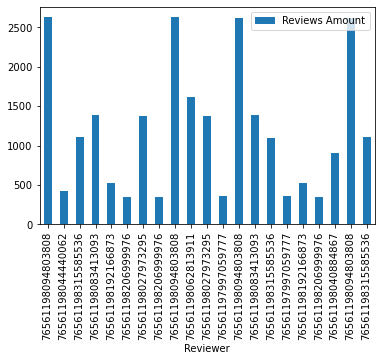

In [97]:
reviewers = pd.DataFrame({'Reviewer':top_10_reviewers['author.steamid'], 'Reviews Amount':top_10_reviewers['author.num_reviews']})
reviewers.plot(x = 'Reviewer', y = 'Reviews Amount', kind='bar')


### What applications did the most popular author review?

In [98]:
most_popular_author = dataframe['author.steamid'].mode()[0]
most_popular_author_reviews = dataframe[dataframe['author.steamid'] == most_popular_author]


In [99]:
print(most_popular_author_reviews[['app_id','app_name']])

         app_id                            app_name
512675       70                           Half-Life
539037      240              Counter-Strike: Source
658130      420            Half-Life 2: Episode Two
849477      620                            Portal 2
1549581    4000                         Garry's Mod
1728583    8930          Sid Meier's Civilization V
2141495  381210                    Dead by Daylight
2252905  289070         Sid Meier's Civilization VI
2392987  264710                          Subnautica
2571139  477160                    Human: Fall Flat
2646056  242920                            Banished
2682381  504230                             Celeste
2708381  240720  Getting Over It with Bennett Foddy
2743294  253230                       A Hat in Time
2913786  242760                          The Forest
3289384  332200                         Axiom Verge
3393685  250900       The Binding of Isaac: Rebirth
3470835  206440                         To the Moon
3474508  200

### How many applications did he purchase, and how many did he get as free? Provide the number (count) and the percentage.

In [100]:
games_received_for_free = most_popular_author_reviews[most_popular_author_reviews['received_for_free'] == True]
games_paid = most_popular_author_reviews[most_popular_author_reviews['received_for_free'] == False]

amount_paid = len(games_paid)
amount_free = len(games_received_for_free)
tot = amount_free + amount_paid

print("Most popular reviewer has : ")
print("{}/{} ({:.2f}%) games that have been purchased".format(amount_paid, tot, 100 * amount_paid / tot))
print("{}/{} ({:.2f}%) games that have been received for free".format(amount_free, tot, 100 * amount_free / tot))

Most popular reviewer has : 
34/35 (97.14%) games that have been purchased
1/35 (2.86%) games that have been received for free


### How many of the applications he purchased reviewed positively, and how many negatively? How about the applications he received for free?

In [101]:
print("Author {} has reviewed positively {} of the {} purchased.".format(most_popular_author, len(games_paid[games_paid['recommended'] == True]), amount_paid))
print("Author {} has reviewed negatively {} of the {} purchased.".format(most_popular_author, len(games_paid[games_paid['recommended'] == False]), amount_paid))
print("Author {} has reviewed positively {} of the {} purchased.".format(most_popular_author, len(games_received_for_free[games_received_for_free['recommended'] == True]), amount_free))
print("Author {} has reviewed negatively {} of the {} purchased.".format(most_popular_author, len(games_received_for_free[games_received_for_free['recommended'] == False]), amount_free))

Author 76561198062813911 has reviewed positively 34 of the 34 purchased.
Author 76561198062813911 has reviewed negatively 0 of the 34 purchased.
Author 76561198062813911 has reviewed positively 1 of the 1 purchased.
Author 76561198062813911 has reviewed negatively 0 of the 1 purchased.


# [RQ6] It's time to get information from the updates that a user does to his reviews.
---

### What is the average time (days and minutes) a user lets pass before he updates a review?

In [102]:
# Filtering out reviews that don't have updated timestamp
updated_reviews = dataframe[dataframe['timestamp_updated'].notnull()]
updated_reviews = updated_reviews[updated_reviews['timestamp_updated'] != updated_reviews['timestamp_created']]

In [103]:
time_between_updates = updated_reviews.apply(lambda row : (datetime.fromtimestamp(row['timestamp_updated']) - datetime.fromtimestamp(row['timestamp_created'])), axis=1)

In [104]:
average_time_between_updates = np.mean(time_between_updates)
print(average_time_between_updates)

369 days 15:49:46.837960392


### Plot the top 3 authors that usually update their reviews.

<AxesSubplot:title={'center':'Top 3 Review Updaters'}, xlabel='Reviewers', ylabel='Updates Amount'>

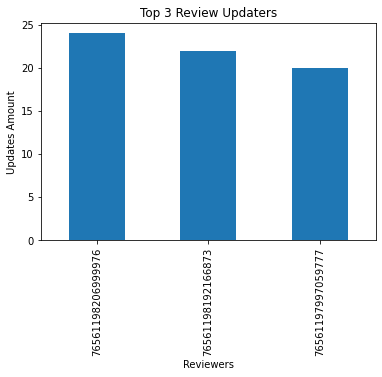

In [105]:
most_frequent_updaters = (updated_reviews['author.steamid'].value_counts()[:3])
most_frequent_updaters.plot(kind='bar', title ="Top 3 Review Updaters", xlabel="Reviewers", ylabel ="Updates Amount")

# [RQ7] Of course, calculating probabilities is a job that any Data Scientist must know. Let's compute Some interesting figures.
---


### What’s the probability that a review has a Weighted Vote Score equal to or bigger than 0.5?

In [106]:
well_voted_reviews = (dataframe[dataframe['weighted_vote_score'] >= 0.5] )

In [107]:
well_voted_review_probability = len(well_voted_reviews) / len(dataframe)
print('{:.2f}%'.format(100 * well_voted_review_probability))

21.80%


### What’s the probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5?

In [108]:
funny_and_well_voted_reviews = well_voted_reviews[well_voted_reviews['votes_funny'] > 0]

In [109]:
funny_and_well_voted_reviews_probability = (len(funny_and_well_voted_reviews) / len(well_voted_reviews))

In [110]:
print('{:.2f}%'.format(100 * funny_and_well_voted_reviews_probability))

24.80%


### Is the probability that “a review has at least one vote as funny” independent of the “probability that a review has a Weighted Vote Score equal or bigger than 0.5”?

by definition probs are indipendent if the prob of their interception is equal to p(a) * p(b).. so...

In [111]:
funny_reviews = dataframe[dataframe['votes_funny'] > 0]
funny_well_voted_interception = (dataframe.query('votes_funny > 0 & weighted_vote_score >= 0.5'))

In [112]:
funny_reviews_probability = len(funny_reviews)/len(dataframe)

funny_times_well_voted_probability = funny_reviews_probability * well_voted_review_probability
funny_well_voted_interception_probability = len(funny_well_voted_interception)/len(dataframe)

In [113]:
print(funny_well_voted_interception_probability == funny_times_well_voted_probability)

False


# [RQ8] Every decision you take in a data-based environment should be reinforced with charts, statistical tests and analysis methods to check if a hypothesis is correct or not.
---

### Is there a significant difference in the Weighted Vote Score of reviews made in Chinese vs the ones made in Russian? Use an appropriate statistical test or technique and support your choice.


<class 'list'>


<Figure size 432x288 with 0 Axes>

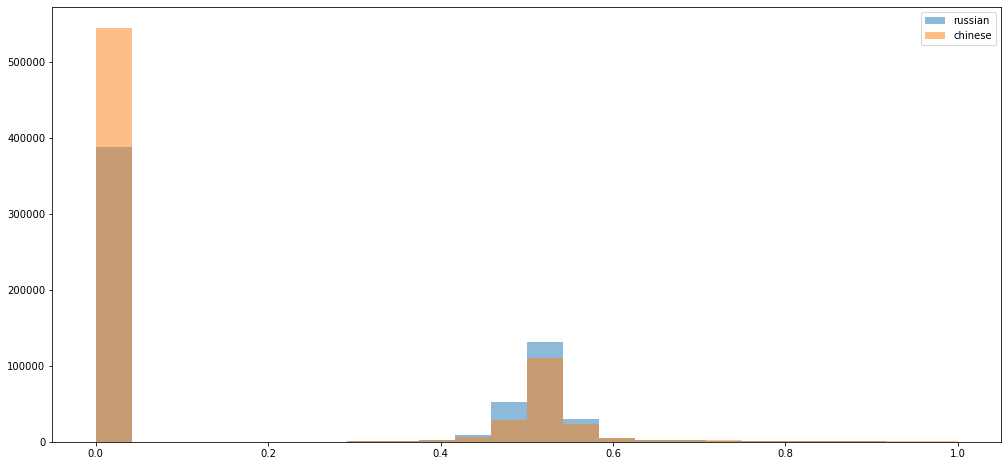

The p-value of the test is:  0.0


In [114]:
#from scipy.stats import mannwhitneyu
import scipy.stats as stats
#from scipy.stats import wilcoxon
from scipy.stats import ks_2samp


dataframe_chin_rus=dataframe[(dataframe['language']=='schinese') | (dataframe['language']=='russian') ]
dataframe_chin_rus=dataframe_chin_rus[['weighted_vote_score','language']]
df_weight_rus = dataframe_chin_rus[dataframe_chin_rus['language']=='russian']['weighted_vote_score'].tolist()
df_weight_chin = dataframe_chin_rus[dataframe_chin_rus['language']=='schinese']['weighted_vote_score'].tolist()

print(type(df_weight_rus))
#print(df_weight_rus.describe())
#print(df_weight_chin.describe())

#print('Mean of weighted scores of the Russian reviews are :',df_weight_rus.mean(),
#      '\nMean of weighted scores of the chinese reviews are : ',df_weight_chin.mean())

plt.figure()
fig=plt.figure(figsize=(17,8))

bins=np.linspace(0,1,25)
plt.hist(df_weight_rus, bins,alpha=0.5, label="russian")
plt.hist(df_weight_chin, bins,alpha=0.5, label="chinese")
plt.legend(loc='upper right')
plt.show()

#w,p=mannwhitneyu(df_weight_rus,df_weight_chin)
w,p = ks_2samp(df_weight_rus,df_weight_chin)
ttest=stats.ttest_ind(df_weight_rus,df_weight_chin, equal_var=False)

print('The p-value of the test is: ',p)


We are confronting two distributions, the Chinese weighted score and the Russian weighted score. 
- In this case, we don't have normal distributed values, so we are going to use the Kolmogorov-Smirnov test of the scipy library: it's a non parametric test for the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y.
- The two means are different, and the significance test results have a p-value of <0.05. We can assume that the two weighted scores are significantly different. 

### Can you find any significant relationship between the time that a user lets pass before he updates the review and the Weighted Vote Score? Use an appropriate statistical test or technique and support your choice.


In [115]:
import seaborn as sns 
timeframes = pd.to_datetime(dataframe['timestamp_created'].apply(lambda time : (datetime.fromtimestamp(time))))
timeframes_upd = pd.to_datetime(dataframe['timestamp_updated'].apply(lambda time : (datetime.fromtimestamp(time))))
#The difference between updated time and created time gives us the Gap time between updation.
timeframe_gaptime = timeframes_upd - timeframes
timeframe_gaptime= timeframe_gaptime / np.timedelta64(1, 's')


weighted = dataframe['weighted_vote_score']

data={'Gaptime': timeframe_gaptime,
      'VotedWeights' : weighted,
      'Recommended': dataframe['recommended']
     }
time_weight_df=pd.DataFrame(data)


<Figure size 432x288 with 0 Axes>

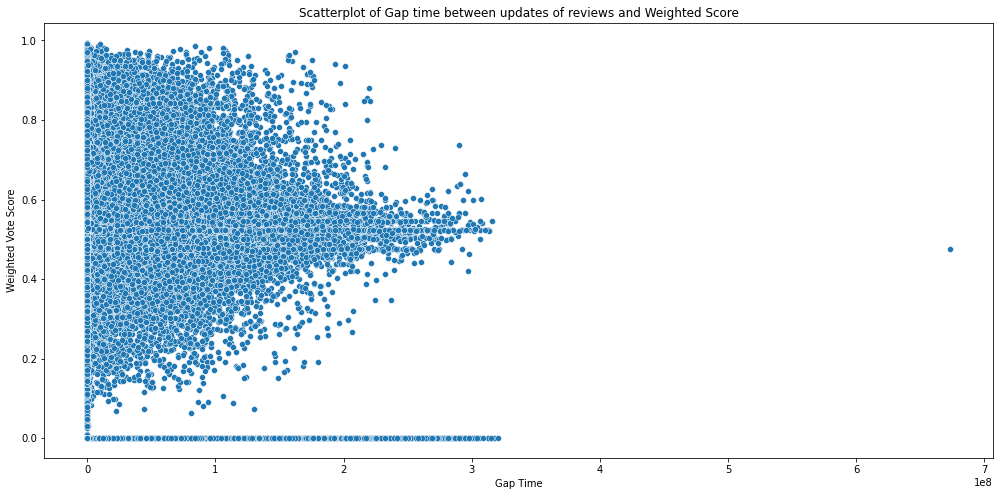

The R-Squared value of the correlation between Weighted score and GapTime is:  -0.04103767238264977


In [116]:
##plot
plt.figure()
fig=plt.figure(figsize=(17,8))
sns.scatterplot(data=time_weight_df, x='Gaptime', y='VotedWeights')
plt.title('Scatterplot of Gap time between updates of reviews and Weighted Score')
plt.xlabel('Gap Time')
plt.ylabel('Weighted Vote Score')
plt.show()

from sklearn.metrics import r2_score

print('The R-Squared value of the correlation between Weighted score and GapTime is: ',r2_score(time_weight_df['Gaptime'],time_weight_df['VotedWeights'] ))

From the scatter-plot we can see how there is no linear correlation between the variables, with a low R_Squared measure. 

### Is there any change in the relationship of the variables mentioned in the previous literal if you include whether an application is recommended or not in the review? Use an appropriate statistical test or technique and support your choice.

In [ ]:
plt.figure()
fig=plt.figure(figsize=(15,8))
sns.scatterplot(data=time_weight_df, x='Gaptime', y='VotedWeights', hue='Recommended')
plt.title('Scatterplot of Gap time between updates of reviews and Weighted Score')
plt.xlabel('Gap Time')
plt.ylabel('Weighted Vote Score')
plt.show()

print('The R-Squared of the Recommended reviews is :',
      r2_score(time_weight_df[time_weight_df['Recommended']==True]['Gaptime'],
time_weight_df[time_weight_df['Recommended']==True]['VotedWeights'] ))

print( 'The R-Squared of the Not Recommended reviews is : ', 
r2_score(time_weight_df[time_weight_df['Recommended']==False]['Gaptime'],
time_weight_df[time_weight_df['Recommended']==False]['VotedWeights'] ))


<Figure size 432x288 with 0 Axes>

There is no real difference, even if we analyze according the Recommended variable.

### What are histograms, bar plots, scatterplots and pie charts used for?

This techniques of presenting data are really useful when we want to present in a visible way the relation between our variables. ###to be continued

### What insights can you extract from a Box Plot?

A Boxplot is a simple graphic way to represent our data: a rectangle is drawn #to be continued

In [ ]:
#example of boxplot
dataframe_chin_rus.boxplot(column=['weighted_vote_score'], by=['language'],figsize=(9,6))

# Teoretical Questions 
---

# [TQ1]

We are given the following algorithm.
```
Input: 
    A: array of length n
    k: integers between 1 and n
    
function alg(A, k):
  s <-- a random element of A
  set L = [all the elements of A with value <= s]
  set R = [all the elements of A with value > s]
  r = len(L)
  if k == r:
    return s
  else if k < r:  
    return alg(L, k)
  else:
    return alg(R, k - r)
```
What does the algorithm compute?
What is asymptotically (i.e., we are asking for big-O complexity) the running time of the algorithm in the worst case, as a function of n?
What is asymptotically the running time of the algorithm in the best case?

# TQ2
You are given the recursive function splitSwap, which accepts an array a, an index i, and a length n.
```
function splitSwap(a, l, n):
  if n <= 1:
    return
  splitSwap(a, l, n/2)
  splitSwap(a, l+ n /2, n/2)
  swapList(a, l, n)
The subroutine swapList is described here:

function swapList(a, l, n):
  for i = 0 to n/2:
    tmp = a[l + i]
    a[l + i] = a[l + n/2 + i]
    a[l + n/2 + i] = tmp
 ```
How much running time does it take to execute splitSwap(a, 0, n)? (We want a Big O analysis.)
What does this algorithm do? Is it optimal? Describe the mechanism of the algorithm in details, we do not want to know only its final result.
HINT: Consider the scenario where len(a) and n are numbers that are a power of 2.

---

### How does it work?
This algorithm is designed to *split* **a** (the input) starting from index *L* and to swap every item after its *Lth*.  

The algorithm implements a recursive function that modifies the input by enqueueing operations in a tree-like structure, with depth equal to :    
**2^d = N**.   
Where d is the *depth*

Visually:    
<img src="https://user-images.githubusercontent.com/50860347/139086690-4bf9b177-1231-4a08-aa1e-adde8215eaa6.jpg" alt="Tree structure" width="400"/>

The tree is then computed by visiting the left child first [**splitSwap(a, l, n/2)**], then the right one [**splitSwap(a, l+ n /2, n/2)**] and at last their parent: [**splitSwap(a, l, n)**].

In order to work without throwing errors the algorithm requires some **constraints** to be respected: In particular, N has to be smaller than len(a)/2 and l+N has to be smaller than len(a).   This is required to avoid **Index Out Of Bound Exceptions**

# git is **kinda** fun